# YOUR PROJECT TITLE

Imports and set magics:

In [1]:
import numpy as np
from scipy import optimize
from scipy import linalg
from scipy import interpolate 
import sympy as sm

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
import modelproject

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## Model description

We consider the **Ramsey Model** from macro 3, in which we consider 2 sectors:

**households** own capital, supply labor and consume
**firm** give out capital and hire labor for production

there are 4 variables
**capital**: ${K_t}$
**labor**: ${L_t}$
**output**: ${Y_t}$
**consumption**: ${C_t}$

for individuals there are
output per capita ${y_t}$ = ${Y_t}$/ ${L_t}$, capital per capita ${k_t}$ = ${K_t}$/${L_t}$, consumption per capita ${c_t}$ = ${C_t}$/${L_t}$

**prices** are taken as given by households and firms 
${r_t}$: capital rent rate
${w_t}$: wage rate

return on capital owned by households, depreciation rate $\delta$>0
$$ {R_t} = 1 + {r_t} - {\delta} $$

**Firms** production function is given by:
$$ Y_t = F(K_t,L_t) = f(k_t)L_t $$

Firm profit maximization:
$$ max_{k_t,l_t} f(k_t)L_t - r_tK_t - w_tL_t $$

With FOC
$$ f'(k_t) = r_t $$
$$ f(k_t) - f'(k_t)k_t = w_t $$

considering the case with **Cobb-Douglas Production** function:
$$ F(K_t,L_t) = AK^{\alpha}L^{1-\alpha} $$

$$f(k_t) = Ak_t^{\alpha} $$

and now $ r_t = A{\alpha}k_t^{\alpha-1}$, $w_t=  A(1-\alpha)k_t^{\alpha} $

**Households** maximize utility from consumption:
$$ max_{c_t} \sum_{t=0}^{\infty} \beta^t u(c_t), u'>0, u''<0 $$ 

under constraint 
$$ k_{t+1} = R_tk_t + w_t - c_t $$

with given $k_0 $, $ ({R_t})_{t=0}^{\infty} $ and  $ ({w_t})_{t=0}^{\infty} $

*optimal behavior* imply euler equation $\frac{u'(c_t)}{u'(c_{t+1})} = \beta{R_{t+1}} $

with *CRRA utility* function $u(c_t) = \frac{c_t^{1-\theta}}{1-\theta}, \theta>0 $

## Analytical solution for Steady State

First we define all **symbols**:

In [3]:
u = sm.symbols('u')
c0 = sm.symbols('c_t')
c1 = sm.symbols('c_{t+1}')
beta = sm.symbols('beta')
R = sm.symbols('R_{t+1}')
theta = sm.symbols('theta')
r = sm.symbols('r_t')
delta = sm.symbols('delta')
A = sm.symbols('A')
alpha = sm.symbols('alpha')
k = sm.symbols('k_t')
w = sm.symbols('w_t')
k_star = sm.symbols('k^*')
c_star = sm.symbols('c^*')

r = A*alpha* k **(alpha-1)
w = A*(1-alpha)*k**alpha
R = 1 + r - delta
k1 = R*k + w - c0

utility function of 2 time period 

In [4]:
u0 = c0**(1-theta)/(1-theta)
u1 = c1**(1-theta)/(1-theta)
(u0,u1)

(c_t**(1 - theta)/(1 - theta), c_{t+1}**(1 - theta)/(1 - theta))

derive eular equation 

In [5]:
euler = sm.Eq(sm.diff(u0,c0)/sm.diff(u1,c1), beta*R)
euler

Eq(c_t**(1 - theta)*c_{t+1}*c_{t+1}**(theta - 1)/c_t, beta*(A*alpha*k_t**(alpha - 1) - delta + 1))

solve euler equation 

In [6]:
sol = sm.solve(euler, c1)
sm.Eq(c1,sol[0])

Eq(c_{t+1}, (beta*c_t**theta*(A*alpha*k_t**alpha - delta*k_t + k_t)/k_t)**(1/theta))

when under steady state $c_t = c_{t+1}$, $k_t = k_{t+1}$, thus

In [7]:
c_steadystate = sm.Eq(sol[0],c0)
c_steadystate

Eq((beta*c_t**theta*(A*alpha*k_t**alpha - delta*k_t + k_t)/k_t)**(1/theta), c_t)

In [8]:
c_sol = sm.solve(c_steadystate,k)

In [9]:
sm.Eq(k_star,c_sol[0])

Eq(k^*, ((beta*(delta - 1) + 1)/(A*alpha*beta))**(1/(alpha - 1)))

Then we define the **steady state capital**

In [10]:
k_steadystate = sm.Eq(k,k1)
k_steadystate

Eq(k_t, A*k_t**alpha*(1 - alpha) - c_t + k_t*(A*alpha*k_t**(alpha - 1) - delta + 1))

and **solve** it

In [11]:
k_sol = sm.solve(k_steadystate,c0)[0]
sm.Eq(c_star,k_sol)

Eq(c^*, A*k_t**alpha - delta*k_t)

Define the model **parameters**:

In [12]:
A = 1
alpha = 0.4
delta = 0.1
beta = 0.7
theta = 0.2

## Numerical solution

In [13]:
# define production function:
def f(k):
    """
    Input:
        k_t: period_0 capital per worker
        
    Return:
        f_t: period_0 output per worker
        
    """
    return A*k**alpha

# define rate of capital:
def r(k):
    """
    Input:
        k_t: period_0 capital per worker
        
    Return:
        r_t: period_0 rate of capital per worker
        
    """
    return A*alpha*k**(alpha-1)

# define wage rate:
def w(k):
    """
    Input:
        k_t: period_0 capital per worker
        
    Return:
        w_t: period_0 wage rate per worker
        
    """
    return A*(1-alpha)*k**alpha

# define return on capital
def R(k):
    """
    Inputs:
        k_t: period_0 capital per worker
        
    Returns:
        R_t: period_0 return on capital
        
    """
    return 1+ r(k) - delta

define function which calculates the period 1 capital stock per capita.

In [14]:
def capital(k,c):
    """
    Input:
        1) k_t: period_0 capital per capita
        2) c_t: period_0 consumption per capita
        
    Returns:
        1) k_t+1: period_1 capital per capita
    """    
 
    return (R(k))*k - w(k) - c

define a function which calculates the next period consumption derived form euler equation.

In [15]:
def consumption(k,c):
    """
    Input:
        1) k_t: period_0 capital per capita
        2) c_t: period_0 consumption per capita
        
    Return:
        1) c_t+1: period_1 consumption per capita        
    """
    return (beta*R(k))**(1/theta)*c 

define a function in which func_1, func_2= 0

In [16]:
# function 1 express the change in capital stock per capita between 2 periods.
def func_1(k,c):
    return capital(k,c) - k

# when under steady state capital(k,c) - k = 0 

In [17]:
# function 2 express the change in consumption per capita between 2 periods
def func_2(k,c):
    return consumption(k,c) - c

# when under steady state consumption(k,c) - c = 0

In [18]:
def steadystate(x):
    result = [func_1(x[0],x[1])]
    result.append(func_2(x[0],x[1]))
    return result

In [19]:
# make initial guess
k0,c0 = 1,1

# imply solver to calculate steady state
k_star, c_star = optimize.fsolve(func=steadystate,x0=(k0,c0))

print ("Numeric k*:  ", k_star)
print ("Numeric c*:  ", c_star)

Numeric k*:   0.628435213472863
Numeric c*:   -0.22892997062284345


define functions with capital k and consumption c on steady state:

In [20]:
# define steady state capital k _star
def k_star():
    return ((beta*(delta-1) + 1)/(A*alpha*beta))**(1/(alpha-1))

# steady state consumption c_star
def c_star():
    return A*k_star()** alpha - delta*k_star()

In [21]:
print ("Analytic k*:", k_star())
print ("Analytic c*:", c_star())

Analytic k*: 0.6284352134762944
Analytic c*: 0.7675887250317597


## Visualization 

In [22]:
#a. locus for capital
def locus(k):
    return f(k) - delta*k

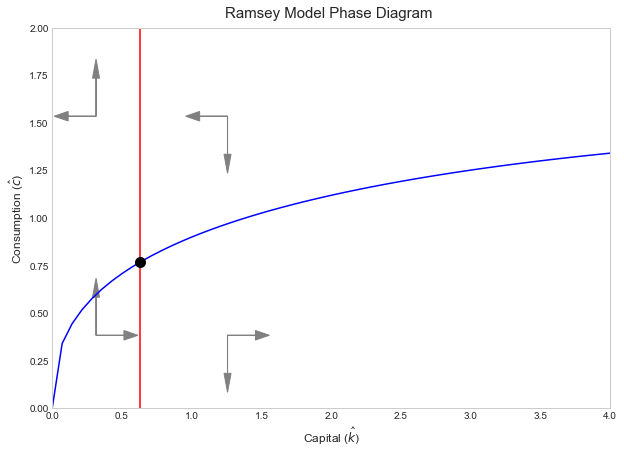

In [23]:
#b. Create a grid of points for plotting
xs = np.linspace(0, 500, 7000)

#c. Constructing the generic phase diagram 
phase = plt.figure(figsize=(10,7))
plt.xlim(0,4)
plt.ylim(0,2)
plt.grid(False)
plt.xlabel([])

#c.1 Adding the capital and consumption locii
plt.plot(xs, locus(xs), linestyle ='-', color='blue') 
plt.axvline(k_star(), linestyle = '-', color = 'red')
plt.plot(k_star(), c_star(), marker='o', markersize = 10, color ='black')

#c.2 Adding arrows to indicate dynamics 
plt.arrow((1/2)*k_star(), (1/2)*c_star(), dx=0, dy=0.2, head_width = 0.05, head_length= 0.1, color = 'grey')
plt.arrow((1/2)*k_star(), (1/2)*c_star(), dx=0.2, dy=0, head_width = 0.05, head_length= 0.1, color = 'grey')
plt.arrow((1/2)*k_star(), 2*c_star(), dx=0, dy=0.2, head_width = 0.05, head_length= 0.1, color = 'grey')
plt.arrow((1/2)*k_star(), 2*c_star(), dx=-0.2, dy=0, head_width = 0.05, head_length= 0.1, color = 'grey')

plt.arrow(2*k_star(), (1/2)*c_star(), dx=0, dy=-0.2, head_width = 0.05, head_length = 0.1, color = 'grey')
plt.arrow(2*k_star(), (1/2)*c_star(), dx=0.2, dy=0, head_width = 0.05, head_length = 0.1, color = 'grey')
plt.arrow(2*k_star(), 2*c_star(), dx=0, dy=-0.2, head_width = 0.05, head_length = 0.1, color = 'grey')
plt.arrow(2*k_star(), 2*c_star(), dx=-0.2, dy=0, head_width = 0.05, head_length = 0.1, color = 'grey')

#c.3 Adding axis labels and title
plt.xlabel('Capital ($\hat{k}$)', fontsize = 12)
plt.ylabel('Consumption ($\hat{c}$)', fontsize = 12)
plt.title('Ramsey Model Phase Diagram ', fontsize=15, pad = 10)
plt.show()

# Conclusion

ADD CONCISE CONCLUSION.